<a href="https://colab.research.google.com/github/olvad/ML_course_openEdu/blob/main/Homeworks/hw3_linear_regr_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сегодня мы будем работать с линейной регрессией в библиотеке sklearn. Воспользуемся классами с различным типом регуляризации и подберем оптимальные гипер-параметры для этих моделей. Решать будем задачу с Kaggle про предсказание длины поездки в такси [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview).

Первым делом необходимо скачать данные. Воспользуйтесь следующей инструкцией: [Как скачать данные с kaggle в colab.](https://pikabu.ru/story/perevodim_dataset_iz_kaggle_v_google_collabs_9095726) Ниже есть необходимый код, вам нужно лишь запрость токен на kaggle и загрузить его.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Загрузка данных из соревнования по названию

In [ ]:
!kaggle competitions download -c nyc-taxi-trip-duration

 93% 80.0M/85.8M [00:01<00:00, 77.1MB/s]
100% 85.8M/85.8M [00:01<00:00, 84.6MB/s]


In [ ]:
!unzip nyc-taxi-trip-duration.zip

Archive:  nyc-taxi-trip-duration.zip
  inflating: sample_submission.zip   
  inflating: test.zip                
  inflating: train.zip               


Распакуем данные, которые мы загрузили. Работать будем только с train частью, так как там имеются значения предсказываемой переменной.

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1.0,-73.982155,40.767937,-73.964630,40.765602,N,455.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1.0,-73.980415,40.738564,-73.999481,40.731152,N,663.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1.0,-73.979027,40.763939,-74.005333,40.710087,N,2124.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1.0,-74.010040,40.719971,-74.012268,40.706718,N,429.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1.0,-73.973053,40.793209,-73.972923,40.782520,N,435.0


Мы видим информацию о каждой поездке. Нам известны координаты, время начала поездки, количество пассажиров и т.д. Удалим колонку, которая есть только в обучающей выборке `dropoff_datetime`. Из названия понятно, что используя эту колонку и `pickup_datetime` мы сможем восстановить длину поездки. Очевидно, что в начале поездки `dropoff_datetime` нам недоступна, а значит и для предсказания ее использовать нельзя.

In [ ]:
df = df.drop('dropoff_datetime', axis=1)

Сейчас даты записаны в виде строк. Давайте преобразуем их в питонячие datetime объекты. Таким образом мы сможем выполнять арифметические операции с датами и вытаскивать нужную информацию, не работая со строками.

In [ ]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Давайте разобьем выборку на train и test. Применить функцию `train_test_split` в этот раз не получиться. Мы теперь имеем дело с временными данными и на практике наша модель должна уметь работать во временных периодах, которых нет в обучающей выборке. Поэтому разбивать мы будем датасет по хронологии. Для этого отсортируем датасет по дате и возьмем первые N строк.

In [ ]:
df = df.sort_values(by='pickup_datetime')

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


In [ ]:
df_train = df[:10 ** 6]
df_test = df[10 ** 6:]

Напомню, что мы будем пресказывать переменную trip_duration. Посмотрим на target переменную.

<Axes: >

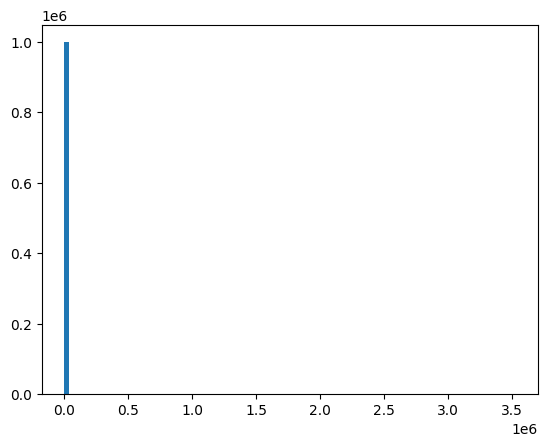

In [ ]:
df_train.trip_duration.hist(bins=100, grid=False, )

Что то пошло не так. Вероятно, есть очень длинные поездки и короткие. Попробуем взять `log(1 + x)` от длины поездки. Единицу мы прибавляем, чтобы избежать проблем с поездками, которые например мнгновенно завершились.

<Axes: >

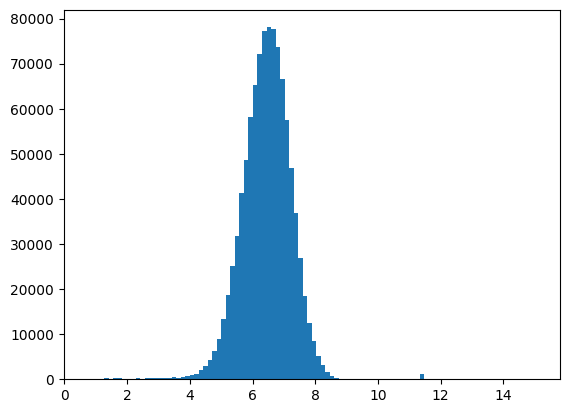

In [ ]:
import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, )

Мы получили куда более ясную картину, распределение стало похоже на нормальное. Работать будем теперь с логарифмом. Так линейной регрессии будет куда проще выучить корректную зависимость. А если захотим вернуться к исходным данным, возведем предсказание в экспоненту.

In [ ]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

<ipython-input-15-05311ce01512>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
<ipython-input-15-05311ce01512>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)


In [ ]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Посмотрим на наши признаки. Давайте нарисуем, как выглядит распределение количества поездок по дням.

<ipython-input-17-3651fb18fc24>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);


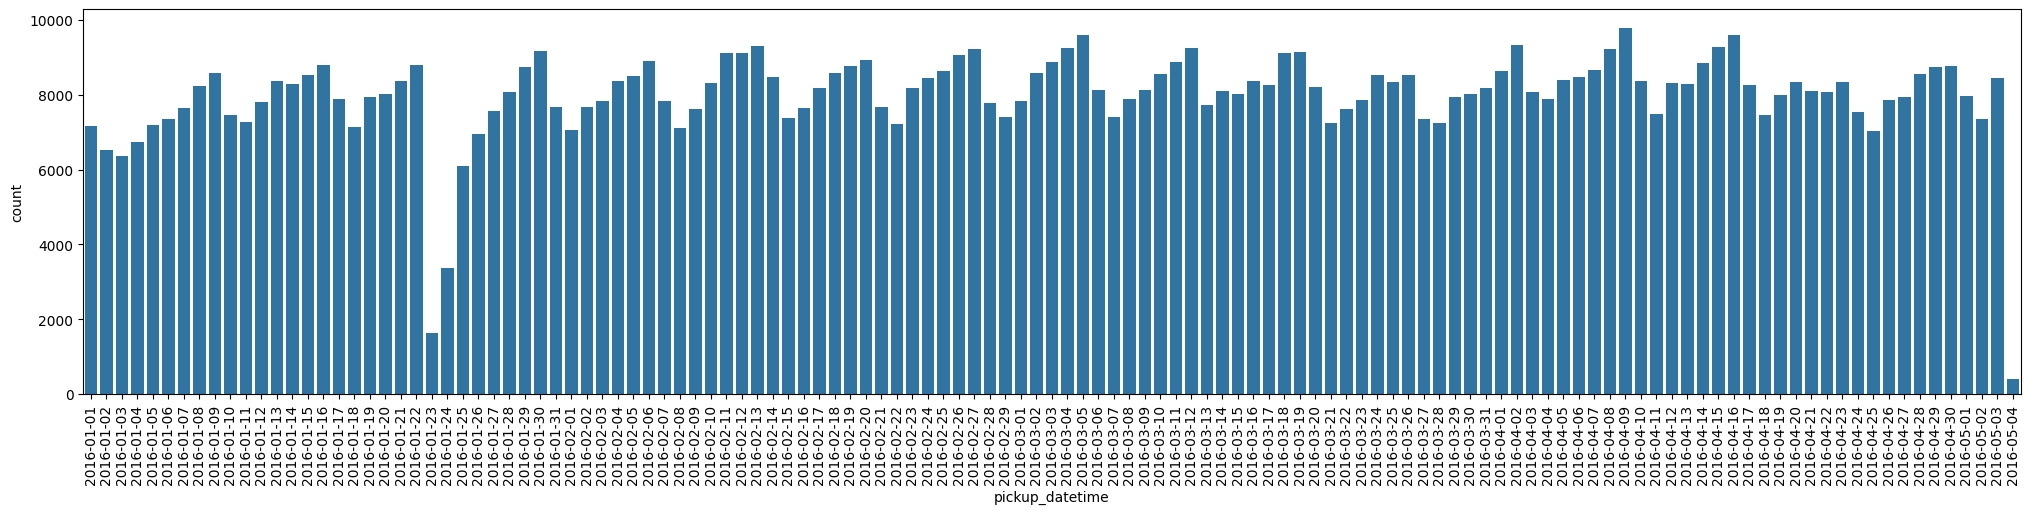

In [ ]:
date_sorted = df_train.pickup_datetime.apply(lambda x: x.date()).sort_values()

plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

Мы можем увидеть паттерны, которые повторяются каждую неделю. Также мы можем наблюдать несколько аномальных правалов в количестве поездок. Посмотрим, как выглядит распределение по часам.

In [ ]:
ddd = df[df['pickup_datetime'].dt.strftime('%d.%m.%Y') == '23.01.2016']

In [ ]:
ddd.vendor_id.nunique()

2

In [ ]:
df.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

<ipython-input-28-3fefb6a2c9b7>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);


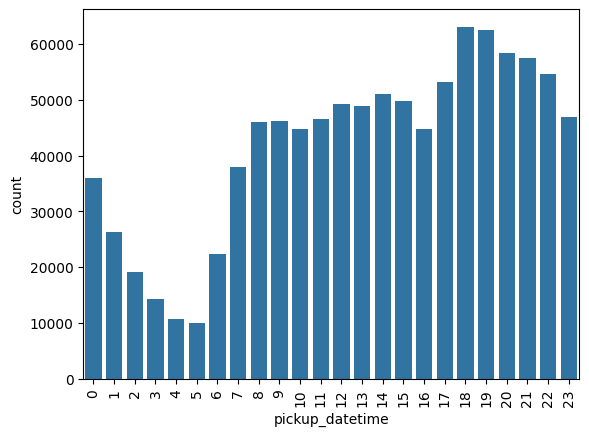

In [ ]:
date_sorted = df_train.pickup_datetime.apply(lambda x: x.hour).sort_values()

date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

Теперь давайте посмотрим, как связан день и длина поездки.

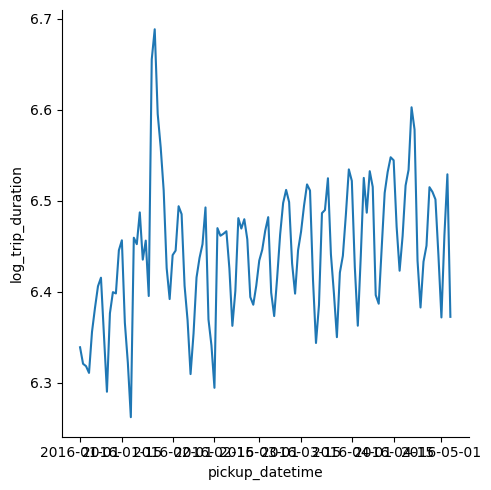

In [ ]:
group_by_weekday = df_train.groupby(df_train.pickup_datetime.apply(lambda x: x.date()))
sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line');

Мы видим явный тренд. Более того, наблюдается такая вещь как сезонность: повторяющиеся временные паттерны. В нашем случае период равен неделе.

Теперь подготовим датасет. Включим в него день года и час дня. Для этого напишем функцию `create_features`, которая будет собирать нам нужные признаки в отдельный `pandas.DataFrame`. В итоге, мы сможем воспользоваться этой функцией, как для train подвыборки, так и для test.

In [ ]:
import datetime
def create_features(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
     ], axis=1, keys=['day', 'hour',]
  )

  return X, data_frame.log_trip_duration

In [ ]:
X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

In [ ]:
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


Переменная час, хоть и является целым числом, не может трактоваться как вещественная. Дело в том, что после 23 идет 0, и что будет означать коэффициент регрессии в таком случае, совсем не ясно. Поэтому применим к этой переменной one -hot кодирование. В тоже время, переменная день должна остаться вещественной, так как значения из обучающей выборке не встреться нам на тестовом подмножестве.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")

In [ ]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Воспользуемся классом `Ridge` и обучим модель.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [ ]:
mean_squared_error(ridge.predict(X_test), y_test)

0.6539687819760848

Давайте попробуем сделать лучше и подберем гиперпараметры модели.

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_searcher = GridSearchCV(Ridge(),
                             param_grid={'alpha': np.linspace(100, 750, 10)},
                             cv=5).fit(X_train, y_train)

In [ ]:
mean_squared_error(grid_searcher.predict(X_test), y_test)

0.6538784861219816

In [ ]:
grid_searcher.best_params_

{'alpha': 388.8888888888889}

# Задание 1
Постройте график соответствующий количеству поездок в зависимости от дня недели по обучающей выборке. Какой из этих графиков соответствует правильному?


<ipython-input-42-0beadc5990db>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);


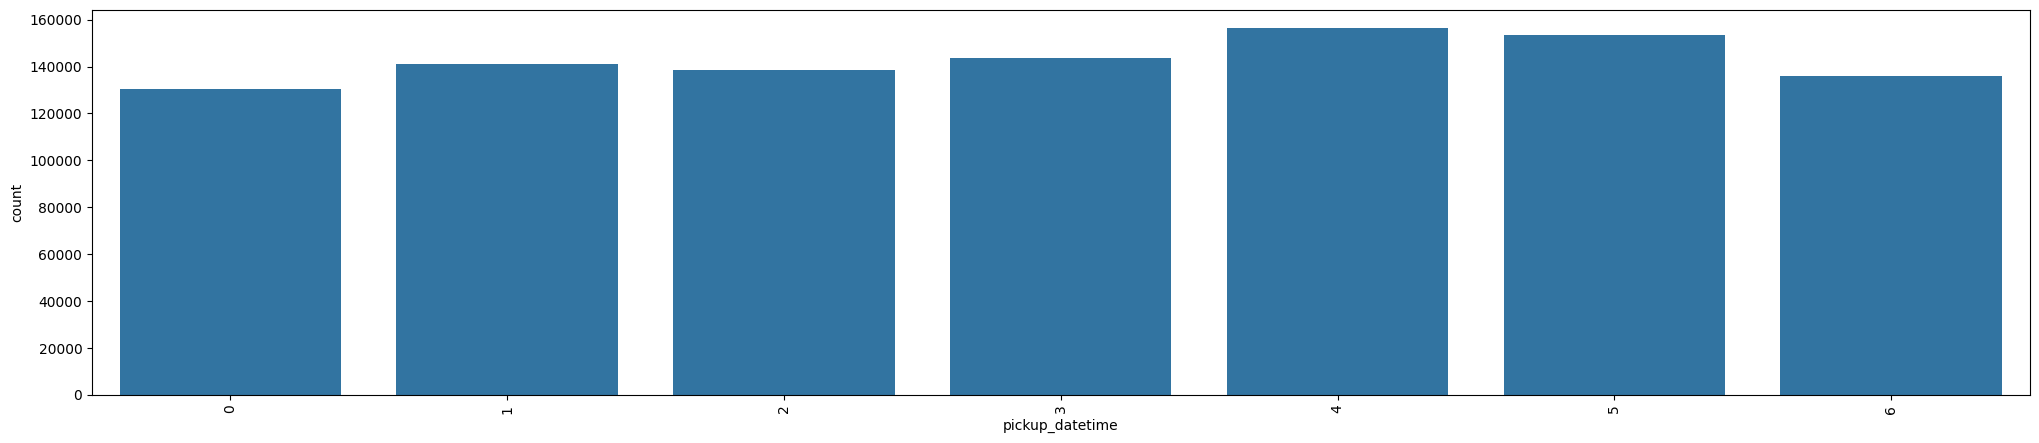

In [ ]:

date_sorted = df_train.pickup_datetime.apply(lambda x: x.dayofweek).sort_values()

plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);


# Задание 2
Добавьте к признакам бинарную переменную, которая равна 1 для двух аномальных дней и 0 во все остальные дни.
Для этого вам понадобиться модифицировать функцию create_features.

In [ ]:
def create_features(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
      pd.to_datetime(data_frame.pickup_datetime).dt.date.isin(['2016-01-23', '2016-02-05']).astype('int')
     ], axis=1, keys=['day', 'hour', 'is_holiday']
  )

  return X, data_frame.log_trip_duration


In [ ]:
X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

ridge = Ridge(alpha=1000).fit(X_train, y_train)
round(mean_squared_error(ridge.predict(X_test), y_test),3)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.654

# Задание 3
1. Добавьте день недели в качестве признака для обучения. Удобнее всего - модифицировать функцию create_features.

2. Заново проведите one-hot кодирование. Сколько признаков у вас получилось?

In [ ]:

def create_features(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
      data_frame.pickup_datetime.apply(lambda x: x.dayofweek),
     ], axis=1, keys=['day', 'hour', 'day_of_week']
  )

  return X, data_frame.log_trip_duration


X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1, 2])], remainder="passthrough")
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

print(f'Количество признаков: {X_train.shape[1]}')




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Количество признаков: 32


In [ ]:


ridge = Ridge(alpha=1000).fit(X_train, y_train)
round(mean_squared_error(ridge.predict(X_test), y_test),3)


0.651

# Вопрос 4

1. Отмасштабируйте единственный вещественный признак.
2. Обучите на полученных данных Lasso регрессию, в качества параметра  `alpha` возьмите 2.65e-05.

Какое качество в терминах MSE вы получили?

Сколько признаков было отобрано? В качестве критерия зануления признака используйте сравнение с $10^{-6}$ (с точностью до 3 знаков после запятой).


In [ ]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=2.65e-05).fit(X_train_scaled, y_train)
a= mean_squared_error(lasso.predict(X_test_scaled), y_test)
print(a)
selected_features = np.sum(np.abs(lasso.coef_) > 1e-6)
print(f"Number of selected features: {selected_features}")


0.650367520458043
Number of selected features: 31


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e+04, tolerance: 6.181e+01
  model = cd_fast.enet_coordinate_descent(
